---
bibliography: ../citations.bib
---

# Data Cleaning

Now that we have gathered a reasonable amount of textual and record data, we can begin the data cleaning process. Our ultimate goal is to do statistical modeling wtih our data, so we need to clean the data. Generally, we will follow the principles of tidy data [@tidydata] in cleaning our data.

# Cleaning Text Data

To begin, we will clean our textual data by parsing out the text from the JSON and HTML objects that were returned from the Reddit and Wikipedia APIs respectively.

## Reddit Data

Recall that the Reddit data was returned as a JSON. We retrieved 10,000 text posts for each of three different text files. Our goal is to turn each of these JSON files into an individual dataframe. From there, we can transform the data into a Bag of Words, Document Term Matrix, or any other helpful format.

We will use `pandas` and `json` to parse this data into a desired output. First let's read in the data.

In [2]:
import pandas as pd
import json

with open("../data/raw_data/reddit_psychosis_data.json") as f:
    reddit_psychosis = json.load(f)
with open('../data/raw_data/reddit_cannabis_data.json') as f:
    reddit_cannabis = json.load(f)
with open("../data/raw_data/reddit_schizophrenia_data.json") as f:
    reddit_schizophrenia = json.load(f)

From the data pull, we know that each of these JSON files has 100 elements, each with 100 posts.

Let's look at the structure of one element to identify how we can extract the title and text information.

In [3]:
reddit_psychosis['0'].keys()

dict_keys(['kind', 'data'])

From here, we see that the posts are within the parameter `children`.

In [4]:
len(reddit_psychosis['0']['data']['children'])

100

It looks like these are the 100 posts we're looking for. Now we'll extract the title and text from each of these children elements.

In [5]:
reddit_psychosis['0']['data']['children'][1]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'upvote_ratio', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'is_created_from_ads_ui', 'author_premium', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'removed_by_category', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'sel

In [6]:
text = reddit_psychosis['0']['data']['children'][1]['data']['selftext']
title = reddit_psychosis['0']['data']['children'][0]['data']['title']

Since we have discovered the structure of this data, we can extract the text info for all of the posts. Let's loop through all three files to get the data in a data frame.

First, we can define function to loop through each of our JSON files.

In [7]:
def parse_reddit_json(reddit_json):
    text_list = []
    title_list = []
    subreddit_list = []
    for i in range(0, 100):
        index = str(i)
        for j in range(0, 100):
            text_list.append(reddit_json[index]['data']['children'][j]['data']['selftext'])
            title_list.append(reddit_json[index]['data']['children'][j]['data']['title'])
            subreddit_list.append(reddit_json[index]['data']['children'][j]['data']['subreddit'])

    return text_list, title_list, subreddit_list

Now, the function parses each of the JSON files and outputs a list of the title of each post and the text contents of each post. All posts have titles, but not all posts have additional text.

In [8]:
psy_text, psy_title, psy_sub = parse_reddit_json(reddit_psychosis)
schiz_text, schiz_title, schiz_sub = parse_reddit_json(reddit_schizophrenia)
cannabis_text, cannabis_title, cannabis_sub = parse_reddit_json(reddit_cannabis)

Now that we have these lists, we can combine them into a `pandas` dataframe where each row is one post on Reddit.

In [9]:
text = psy_text + schiz_text + cannabis_text
title = psy_title + schiz_title + cannabis_title
sub = psy_sub + schiz_sub + cannabis_sub

reddit_df = pd.DataFrame({'text': text, 'title': title, 'subreddit': sub})
reddit_df.head()

,text,title,subreddit
0,3 years post-psychosis in recovery some days c...,first time smiling on camera in... 3 years!,Psychosis
1,,I quit my meds lmfao,Psychosis
2,,I hate it here,Psychosis
3,,art by me. I thought it kinda visualized how I...,Psychosis
4,,But I’m still god and this is neither a joke a...,Psychosis


Now we have a data frame of labeled text objects that will be easy to work with for modeling.

To take this data a step further, we can use a `spacy` pipeline to clean the text. This will do some standard cleaning to deal with things like emails, numbers, extra white space, and punctuation.

In [86]:
reddit_df['all_text'] = reddit_df['title'] + " " + reddit_df['text']
text_list = list(reddit_df[['subreddit', 'all_text']].to_records(index = False))

In [87]:
# Code adapted from DSAN 5800 Lab 2 by Dr. Larson
import spacy

pipeline = spacy.load('en_core_web_sm')

import re
from spacy.language import Language

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "numbr"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Strips extra whitespace
]

for i, (label, text) in enumerate(text_list):
    new_text = text  # Make a copy of the original text
    for repl in replace:
        new_text = re.sub(repl[0], repl[1], new_text)
    text_list[i] = (label, new_text)

@Language.component("DSAN5000")
def DSAN5000_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return pipeline.make_doc(" ".join(tokens))

pipeline.add_pipe("DSAN5000")

<function __main__.DSAN5000_preprocess(doc)>

We can use this pipeline to clean up the text data.

In [89]:
text_list_clean = [(label, pipeline(text)) for label, text in text_list]

In [90]:
text_list_clean[0:5]

[('Psychosis',
  time smile camera numbr year numbr year post psychosis recovery day complete nightmare nightmare u hold long time knock grow strong find breakthrough moment lt;numbr trust friend dm support ❤ ️),
 ('Psychosis', quit med lmfao),
 ('Psychosis', hate),
 ('Psychosis', art think kinda visualize feel),
 ('Psychosis', god joke crisis delusion realization understanding true nature)]

In [94]:
reddit_cleaned_df = pd.DataFrame(text_list_clean, columns=['label', 'text'])
reddit_cleaned_df.to_csv('../data/clean_data/reddit_cleaned_text.csv', index=False)

Now that our data is relatively clean, we can construct a bag of words using `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(text_list_clean)

We can see the most popular words in the corpus:

In [ ]:
vectorizer.vocabulary_

## Wikipedia Data

Next, let's clean up our Wikipedia data. The Wikipedia API returned a complex nested R object. We already extracted the HTML from this R object and stored it in a csv, but we really want the main text of each webpage. 

We will use `rvest` to "harvest" the data from each HTML and store all of the information in a tibble.

In [2]:
library(rvest)

load("../data/raw_data/wikipedia_scrape.Rdata")
wiki_data %>% names()

[1] "title" "text"  "link"

The HTML data is stored in the text column of the data frame. Let's take the first element to parse out the text from each webpage.

In [3]:
first <- wiki_data$text[1]
first %>% 
    read_html() %>%
    html_element("body") %>% 
    html_element("div") %>% 
    html_elements("p") %>% 
    html_text() %>% 
    head()

[1] "The long-term effects of cannabis have been the subject of ongoing debate. Because cannabis is illegal in most countries, clinical research presents a challenge and there is limited evidence from which to draw conclusions.[1] In 2017, the U.S. National Academies of Sciences, Engineering, and Medicine issued a report summarizing much of the published literature on health effects of cannabis, into categories regarded as conclusive, substantial, moderate, limited and of no or insufficient evidence to support an association with a particular outcome.[2]"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
[2] "Cannabis is the most widely used illicit drug in the Western world.[3] In the United States, 10-20% of those who begin the use of cannabis daily will later become dependent.[4][5] Cannabis use can lead to addiction, which is defined as \"when the person cannot stop using the drug even though it interferes with many aspects of his or her life.\"[5][6][7][8] Cannabis use disorder is defined in the fifth revision of the Diagnostic and Statistical Manual of Mental Disorders (DSM-5) as a condition requiring treatment.[3] A 2012 review of cannabis use and dependency in the United States by Danovitch et al said that \"42% of persons over age 12 have used cannabis at least once in their lifetime, 11.5% have used within the past year, and 1.8% have met diagnostic criteria for cannabis abuse or dependence within the past year. Among individuals who have ever used cannabis, conditional dependence (the proportion who go on to develop dependence) is 9%.\" Although no medication is known to be effective in combating dependency, combinations of psychotherapy such as cognitive behavioural therapy and motivational enhancement therapy have achieved some success.[9]"
[3] "Cannabis dependence develops in 9% of users, significantly less than that of heroin, cocaine, alcohol, and prescribed anxiolytics,[10] but slightly higher than that for psilocybin, mescaline, or LSD. Dependence on cannabis tends to be less severe than that observed with cocaine, opiates, and alcohol.[11] A 2018 academic review, published in partnership with Canopy Growth, discussed the limitations of current studies of therapeutic and non-therapeutic cannabis use, and further stated that the nature of dependence formation among regular marijuana consumers has declined since 2002.[12]"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[4] "Cambridge University published a study in 2015 that showed the surprising fact that in England and Wales, the use of cannabis had decreased. Although there was a reported decrease in use, the need for addiction treatment was surging. The study looked more in depth on how the potency of the cannabis affected someone's dependence on the drug. They tested three different levels of potency and found that the most potent cannabis had the highest amount of dependence. Researchers 

Throughout exploring the structure of the HTML file in Wikipedia, we see that there is a simple way to get all paragraph text from each page. We just need to pull all the text from the `<p>` tags on each page.

Now, we will loop through the tibble to convert the HTML string into a plain text string representing the paragraphs on the Wikipedia page.

In [4]:
text_column <- list()
for(i in 1:nrow(wiki_data)) {
    html <- wiki_data$text[i]
    text_list <- html %>%
        read_html() %>%
        html_element("body") %>%
        html_elements("p") %>%
        html_text()
    text_list <- paste0(text_list, collapse = " ")
    text_column <- append(text_column, text_list)
}

Now we have a list of all the text from each of these HTML files. Let's add this as a new column to our tibble and get rid of the huge HTML strings to decrease our memory footprint.

In [6]:
#| message: false
library(tidyverse)

wiki_data <- wiki_data %>%
    select(-text) %>%
    tibble::add_column(raw_text = text_column)

In [13]:
wiki_data %>%
    unnest(raw_text) %>%
    distinct() %>%
    write_csv("../data/clean_data/wiki_data.csv")

Similar to the Reddit data, let's clean this text by running it through the pipeline we defined earlier.

In [16]:
import pandas as pd

wiki_data = pd.read_csv('../data/clean_data/wiki_data.csv')

In [50]:
wiki_data.head()

,title,link,raw_text,all_text
0,Long-term effects of cannabis,main,The long-term effects of cannabis have been th...,Long-term effects of cannabis The long-term ef...
1,"(C6)-CP 47,497",link,"(C6)-CP 47,497 (CP 47,497 dimethylhexyl homolo...","(C6)-CP 47,497 (C6)-CP 47,497 (CP 47,497 dimet..."
2,"(C9)-CP 47,497",link,"(C9)-CP 47,497 (CP 47,497 dimethylnonyl homolo...","(C9)-CP 47,497 (C9)-CP 47,497 (CP 47,497 dimet..."
3,11-Hydroxy-Delta-8-THC,link,11-Hydroxy-Delta-8-tetrahydrocannabinol (11-OH...,11-Hydroxy-Delta-8-THC 11-Hydroxy-Delta-8-tetr...
4,11-Hydroxy-THC,link,11-Hydroxy-Δ9-tetrahydrocannabinol (11-OH-Δ9-T...,11-Hydroxy-THC 11-Hydroxy-Δ9-tetrahydrocannabi...


In [95]:
wiki_data['all_text'] = wiki_data['title'] + " " + wiki_data['raw_text']
text_list = list(wiki_data[['link', 'all_text']].to_records(index = False))

In [97]:
for i, (label, text) in enumerate(text_list):
    new_text = text
    for repl in replace:
        new_text = re.sub(repl[0], repl[1], new_text)
    text_list[i] = (label, new_text)

In [98]:
text_list_clean = [(label, pipeline(text)) for label, text in text_list]

In [99]:
text_list_clean[0:5]

[('main',
  long term effect cannabis long term effect cannabi subject ongoing debate cannabis illegal country clinical research present challenge limited evidence draw conclusion numbr numbr u s national academies sciences engineering medicine issue report summarize publish literature health effect cannabi category regard conclusive substantial moderate limited insufficient evidence support association particular outcome numbr cannabis widely illicit drug western world numbr united states numbr numbr% begin use cannabis daily later dependent numbr][numbr cannabis use lead addiction define person stop drug interfere aspect life numbr][numbr][numbr][numbr cannabi use disorder define fifth revision diagnostic statistical manual mental disorders dsm numbr condition require treatment numbr numbr review cannabis use dependency united states danovitch et al say numbr% person age numbr cannabi lifetime numbr numbr% past year numbr numbr% meet diagnostic criterion cannabis abuse dependence pas

In [100]:
wiki_cleaned_df = pd.DataFrame(text_list_clean, columns=['link', 'text'])
wiki_cleaned_df.to_csv('../data/clean_data/wiki_cleaned_text.csv', index=False)

Now we have our text data from Wikipedia in a data frame with labels representing whether the page was a forward or backward link for the page titled "Long-term effects of cannabis."

# Record Data

Now, we will begin the process of cleaning our record data. We will start by focusing on Setién-Suero and her data regarding the differences in the effects on cannabis on men and women [@Setién-Suero2017].

In [4]:
s1 <- read_csv("../data/s1file.csv")
s2 <- read_csv("../data/s2file.csv")
s1 %>% names()

Rows: 549 Columns: 102
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (102): Code, Program, sex, age, age_psychosis, famhis, hospita, dui, dup...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 477 Columns: 65
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (65): code, Program, sex, age, agepsychosis, fampsic, hospita, dui, dup,...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Code"              "Program"           "sex"              
  [4] "age"               "age_psychosis"     "famhis"           
  [7] "hospita"           "dui"               "dup"              
 [10] "levelsocioeco"     "urbanarea"         "livingwithparents"
 [13] "unmarried"         "unemployed"        "years_edu"        
 [16] "CannabisBinary"    "joints"            "cannabisonset"    
 [19] "durationcannabis"  "SAPS0"             "SANS0"            
 [22] "Psychoticdim0"     "Disorganizeddim0"  "Negativedimen0"   
 [25] "dasgl0"            "gaf0"              "avlla0"           
 [28] "avllv0"            "avlto0"            "avllb0"           
 [31] "avlvi0"            "avldi0"            "avlre0"           
 [34] "comisi0"           "waisd0"            "waisdp0"          
 [37] "waisdd0"           "waisdi0"           "spandir0"         
 [40] "spanin0"           "gpdo0"             "gpndo0"           
 [43] "gpdofinal"         "cptre0"            "cptco0"           
 [46] "cptom0"            "cpter0"            "cpttr0"           
 [49] "fcrco0"            "fcrri0"            "fcrrd0"           
 [52] "fcrtco0"           "tmta0"             "tmtae0"           
 [55] "tmtb0"             "tmtbe0"            "TMTf"             
 [58] "waisvd0"           "waisv0"            "waiscnd0"         
 [61] "waiscn0"           "Diagnosisobinnary" "insight"          
 [64] "dasgl3y"           "gaf3y"             "SAPS3y"           
 [67] "SANS3y"            "Psychotic3y"       "disorganized3y"   
 [70] "Negative3y"        "tmtb0bis"          "gpdo0bis"         
 [73] "zavldi0"           "zfcrrd0"           "zwaiscn0"         
 [76] "zwaisdi0"          "ztmtb0"            "zgpdo0"           
 [79] "zcptco0"           "Tavldi0"           "Tfcrrd0"          
 [82] "Twaiscn0"          "Twaisdi0"          "Ttmtb0"           
 [85] "Tgpdo0"            "Tcptco0"           "g_Tcptco0"        
 [88] "g_Tavldi0"         "g_Tfcrrd0"         "g_Twaiscn0"       
 [91] "g_Twaisdi0"        "g_Ttmtb0"          "g_Tgpdo0"         
 [94] "GDS"               "DEFICIT_1"         "SAPS1y"           
 [97] "SANS1y"            "psychotic1y"       "diroganized1y"    
[100] "Negative1y"        "dasgl1y"           "gaf1y"

First, let's figure out how much missing data we have.

In [6]:
s1 %>% summarise(across(everything(), ~ sum(is.na(.))))
s2 %>% summarise(across(everything(), ~ sum(is.na(.))))

Code,Program,sex,age,age_psychosis,famhis,hospita,dui,dup,levelsocioeco,...,g_Tgpdo0,GDS,DEFICIT_1,SAPS1y,SANS1y,psychotic1y,diroganized1y,Negative1y,dasgl1y,gaf1y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,15,2,1,35,13,18,...,135,172,172,95,101,92,93,98,102,263


code,Program,sex,age,agepsychosis,fampsic,hospita,dui,dup,levelecon,...,gaf1y,avldi3a,waisdi3a,gpdo3a,fcrrd3a,tmta3a,tmtb3a,waisv3a,waiscn3a,cptco3a
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,5,2,0,23,5,12,...,241,255,256,260,255,255,260,270,256,264


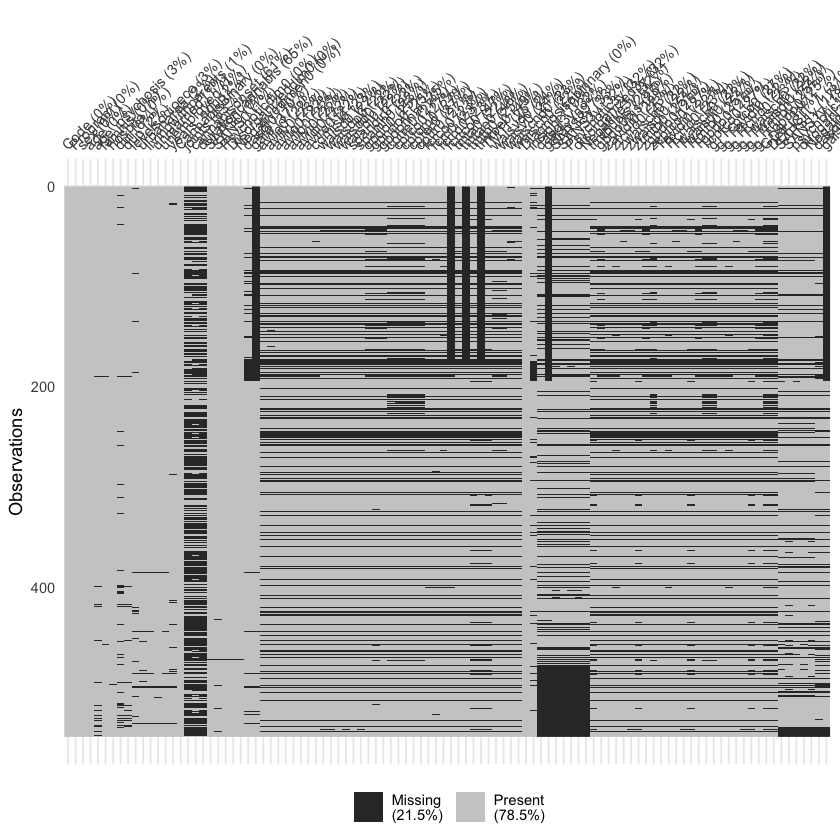

In [7]:
library(visdat)

vis_miss(s1)

A quick visualization of our data show that there are some columns with high completeness, a some columns with larger amounts of missing data. To remedy this, we can remove the columns with large amount of missing data. Let's remove all columns with more than 10% of data missing.

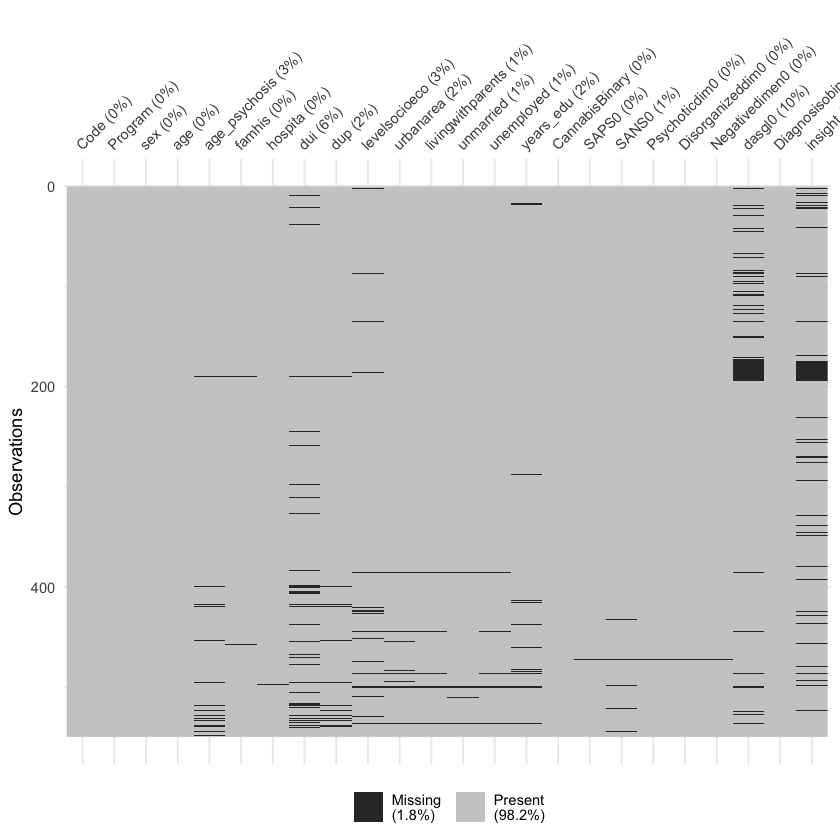

In [8]:
s1 <- s1 %>%
    select(where(~ sum(is.na(.)) < 55))

s2 <- s2 %>%
    select(where(~ sum(is.na(.)) < 48))

s1 %>% vis_miss()

Now our data has a much more acceptable amount of missing information, and we have gotten rid of some superfluous fields. 

Next, let's take a look at some of the binary fields. I notice that they seem to use 1 and 2 rather than the standard 0 and 1.

In [9]:
s1 %>% 
    summarise(across(everything(), ~n_distinct(.))) %>% 
    select(where(~ . <= 2))

sex,CannabisBinary,Diagnosisobinnary
<int>,<int>,<int>
2,2,2


In [12]:
s2 %>% 
    summarise(across(everything(), ~n_distinct(.))) %>% 
    select(where(~ . <= 2))

sex,hospita,CannabisBinary,Diagnosisbinario
<int>,<int>,<int>,<int>
2,2,2,2


In [11]:
s1 %>%
    select(sex, CannabisBinary, Diagnosisobinnary) %>%
    distinct()

sex,CannabisBinary,Diagnosisobinnary
<dbl>,<dbl>,<dbl>
2,2,2
1,2,2
1,2,1
1,1,1
2,1,2
2,2,1
1,1,2
2,1,1


In [15]:
s2 %>%
    select(sex, hospita, CannabisBinary, Diagnosisbinario) %>%
    distinct()

sex,hospita,CannabisBinary,Diagnosisbinario
<dbl>,<dbl>,<dbl>,<dbl>
2,2,2,2
1,2,2,2
1,1,2,2
1,2,2,1
1,1,2,1
1,1,1,1
2,2,1,2
2,2,2,1
1,1,1,2


In [18]:
s1 <- s1 %>%
    mutate(
        sex = ifelse(sex == 1, 0, 1),
        CannabisBinary = ifelse(CannabisBinary == 1, 0, 1),
        Diagnosisobinnary = ifelse(Diagnosisobinnary == 1, 0, 1)
    )

In [16]:
s2 <- s2 %>%
    mutate(
        sex = ifelse(sex == 1, 0, 1),
        hospita = ifelse(hospita == 1, 0, 1),
        CannabisBinary = ifelse(CannabisBinary == 1, 0, 1),
        Diagnosisbinario = ifelse(Diagnosisbinario == 1, 0, 1)
    )

We can also visualize the distribution of these binary values. These will demonstrate the sex, cannabis usage, and diagnosis of each participant recorded in the study data.

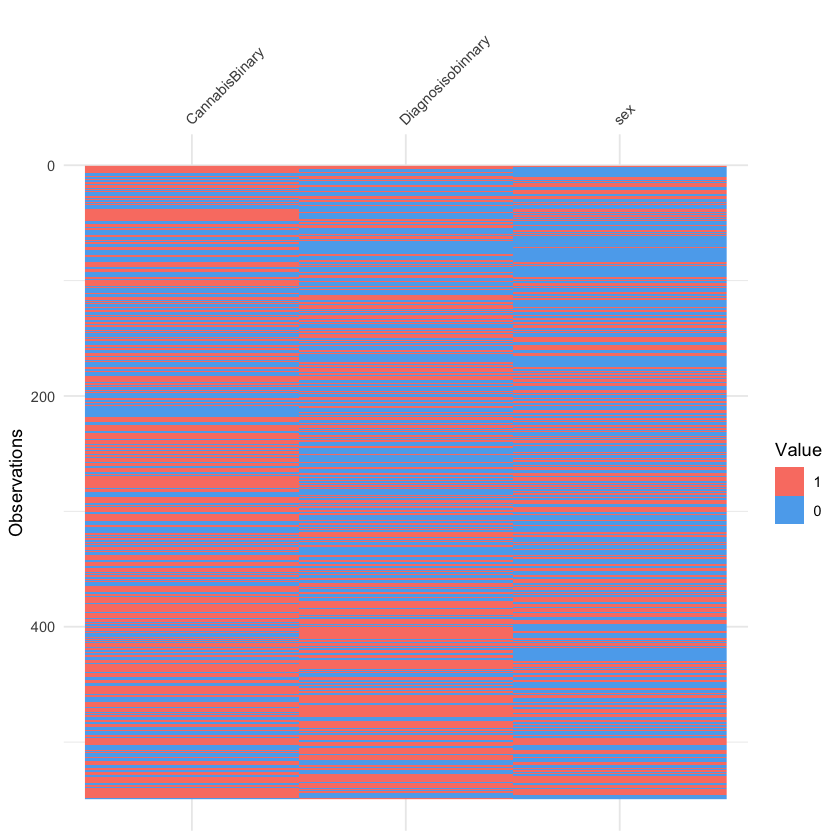

In [19]:
s1 %>%
    select(sex, CannabisBinary, Diagnosisobinnary) %>%
    vis_binary()

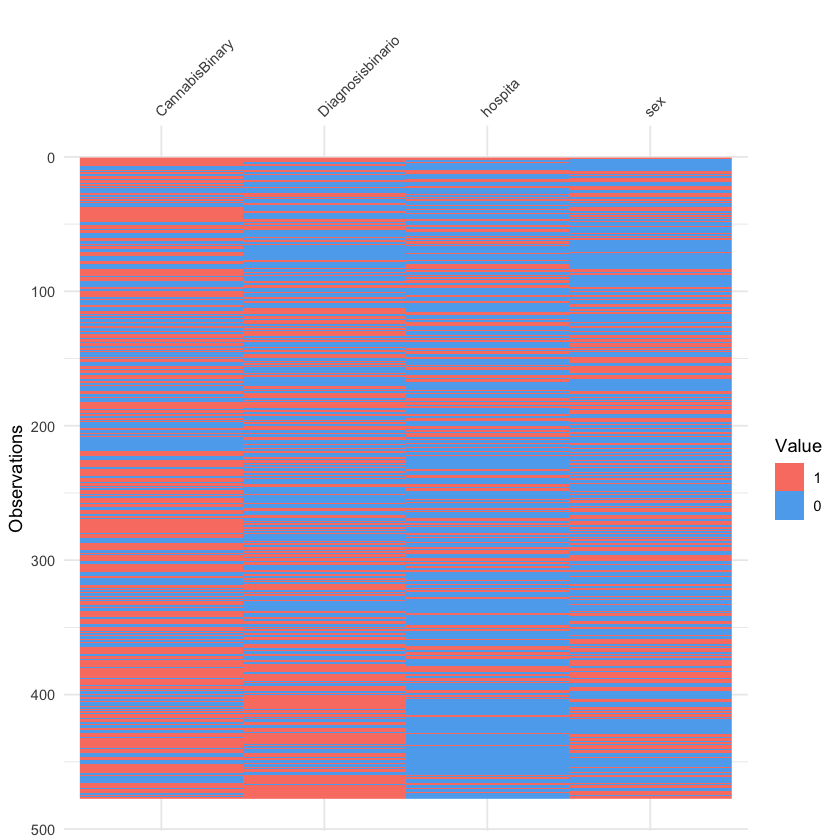

In [21]:
s2 %>%
    select(sex, hospita, CannabisBinary, Diagnosisbinario) %>%
    vis_binary()

In [22]:
s1 %>% write_csv("../data/clean_data/s1file_clean.csv")
s2 %>% write_csv("../data/clean_data/s2file_clean.csv")

Now that our data from Setién-Suero is relatively clean, let's take a look at another dataset.

## Cannabinoids

We can clean @GIBSON2020113380 data set on cannabinoids and their impact on individuals with psychosis. We will start again by visualizing missing data in our table.

New names:
* `` -> `...1`
* `` -> `...2`


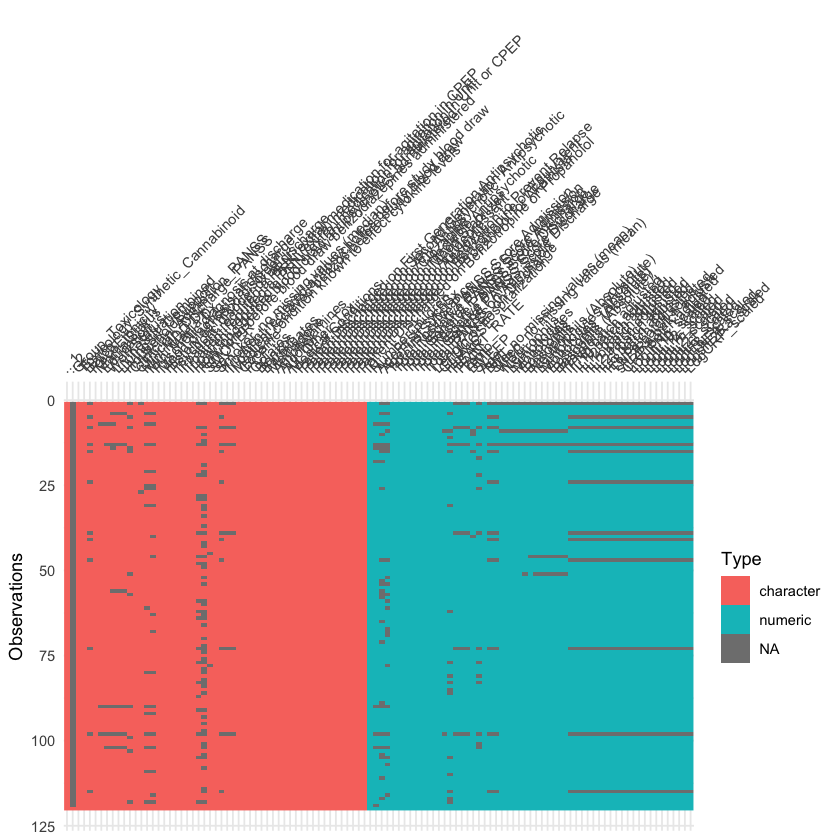

In [63]:
library(readxl)
cannabinoid <- read_excel("../data/raw_data/DataforSumbission_FINAL.xlsx", skip = 1)

cannabinoid %>% vis_dat()

Overall, the completeness of this data is pretty good. We again remove the columns with a high rate of incompleteness. We can also drop rows with missing data because we see a pattern where the missing data tends to collect in rows.

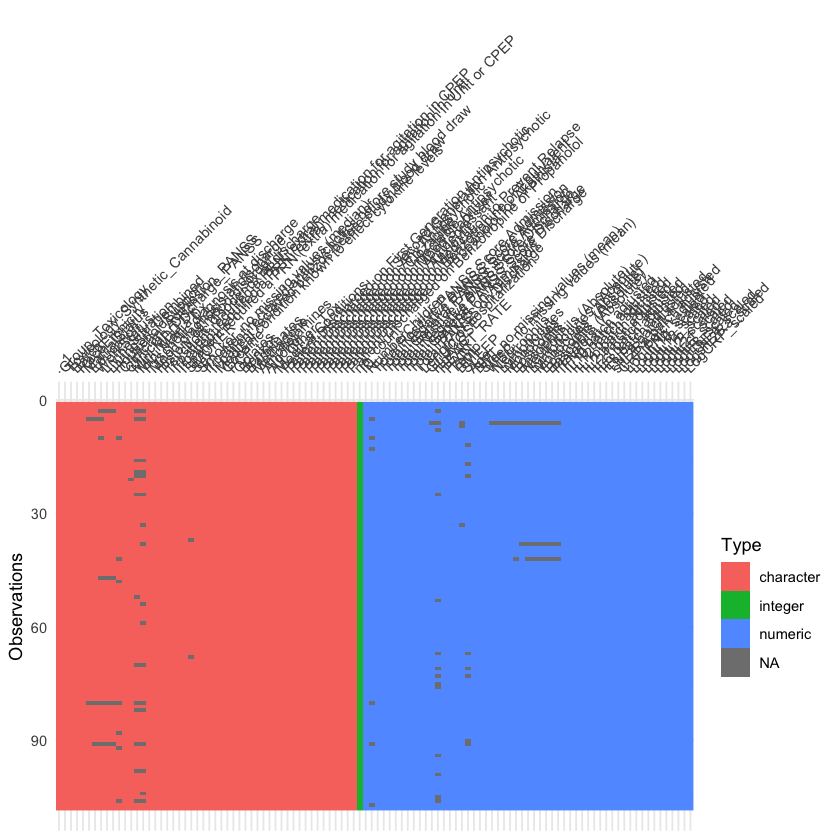

In [96]:
cannabinoid <- cannabinoid %>%
    select(where(~ sum(is.na(.)) < 20))
    
cannabinoid <- cannabinoid %>%
    mutate(na_count = apply(., 1, function(x) sum(is.na(x)))) %>%
    filter(na_count < 20) 
    
cannabinoid %>%
    vis_dat()


I notice that there seem to be a lot of character columns. Let's check to make sure that these columns are standardized and do some cleaning up.

In [102]:
cannabinoid <- cannabinoid %>% select(-`...1`)

In [107]:
name_list <- cannabinoid %>%
    select(where(is.character)) %>%
    names()

In [110]:
for(name in name_list) {
    cannabinoid %>%
        select(all_of(name)) %>% 
        distinct() %>%
        print(n = 10)
}

# A tibble: 3 x 1
  Group_Toxicology    
  <chr>               
1 Cannabinoid-Positive
2 Cannabinoid-Negative
3 119                 
# A tibble: 3 x 1
  Toxicology_Synthetic_Cannabinoid
  <chr>                           
1 Synthetic Cannabinoid Negative  
2 Synthetic Cannabinoid Positive  
3 119                             
# A tibble: 5 x 1
  Batch 
  <chr> 
1 NA    
2 DEC 17
3 MAR 18
4 JUL 18
5 107   
# A tibble: 6 x 1
  RaceEthnicity
  <chr>        
1 Hispanic     
2 Black        
3 White        
4 Asian        
5 Unknown      
6 119          
# A tibble: 6 x 1
  MaritalStatus               
  <chr>                       
1 "Single\u200e/Never married"
2  NA                         
3 "Widowed\u200e/Divorced (?)"
4 "Married"                   
5 "0"                         
6 "116"                       
# A tibble: 6 x 1
  Education               
  <chr>                   
1 Non-high school graduate
2 High school graduate    
3 Some college            
4 College graduate        
5

Generally, these character columns are very clean. However, I want to get rid of the encoding issue causing `\u200e` to appear.

In [127]:
cannabinoid %>%
    filter(if_any(where(is.character), ~str_detect(., "\u200e"))) %>%
    slice_head(n = 1)

ID,Group_Toxicology,Toxicology_Synthetic_Cannabinoid,Batch,RaceEthnicity,MaritalStatus,Education,NumberChildren,WorkStatus,LivingSituation,...,LogIL10_scaled,LogIL12_scaled,LogIL1b_scaled,LogIL2_scaled,LogIL21_scaled,LogIL6_scaled,LogIL8_scaled,LogTNFa_scaled,LogsIL2Ra_scaled,LogCRP_scaled
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,Cannabinoid-Positive,Synthetic Cannabinoid Negative,NA,Hispanic,Single<U+200E>/Never married,Non-high school graduate,0,Not working,Shelter<U+200E>/homeless,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [133]:
cannabinoid <- cannabinoid %>%
    mutate(across(where(is.character), ~str_replace_all(., "\u200e", "")))

cannabinoid %>%
    slice_head(n = 1)

ID,Group_Toxicology,Toxicology_Synthetic_Cannabinoid,Batch,RaceEthnicity,MaritalStatus,Education,NumberChildren,WorkStatus,LivingSituation,...,LogIL10_scaled,LogIL12_scaled,LogIL1b_scaled,LogIL2_scaled,LogIL21_scaled,LogIL6_scaled,LogIL8_scaled,LogTNFa_scaled,LogsIL2Ra_scaled,LogCRP_scaled
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,Cannabinoid-Positive,Synthetic Cannabinoid Negative,NA,Hispanic,Single/Never married,Non-high school graduate,0,Not working,Shelter/homeless,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


 I also notice that there is one row where the values are numeric rather than character. It might be a total row or an error. Let's get rid of that row.

In [112]:
# Confirm that this is only one row
cannabinoid %>%
    filter(Group_Toxicology == 119) %>%
    nrow() %>%
    print()

# Remove the row
cannabinoid <- cannabinoid %>%
    filter(Group_Toxicology != 119)

[1] 1


In [134]:
cannabinoid %>%
    write_csv("../data/cannabinoid_clean.csv")

Now that our data is clean, we can move on to some exploratory data analysis.

In [85]:
research_data <- read_csv("../data/cannabis_research_data.csv")

Rows: 40 Columns: 56
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (4): AdıSoyadı, MeslekDiğerseBelirtiniz, Tanı, TanıDigerseBelirt
dbl (51): Cinsiyeti, Yaş, MedeniDurumu, Çocuk, EgitimDurumu, EğitimSüresi, M...
num  (1): CIDI



i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [86]:
library(deeplr)
name_list <- research_data %>%
    names()


In [31]:
translated_names <- translate2(
    text = name_list,
    target_lang = "EN",
    source_lang = "TR"
    auth_key = "e323baa6-a35d-44dd-7508-2b9259af05f5:fx"
)

In [87]:
names(research_data) <- translated_names

In [88]:
research_data %>%
    select(where(is.character))

NameSurname,OccupationOtherSpecify,Diagnosis,DiagnoseIfDigerseDetermine
<chr>,<chr>,<chr>,<chr>
B.<U+00C7>,NA,NA,NA
C.B.T,NA,Alkol Kulan<U+0131>m Bozuklu<U+011F>u,NA
E.K,NA,Alkol Kulan<U+0131>m Bozuklu<U+011F>u,NA
B.<U+00D6>,NA,Ge<U+00E7>irilmi<U+015F> Depresyon,kumar
E.S,NA,Alkol Kulan<U+0131>m Bozuklu<U+011F>u,DEHB
M.A.T,NA,Ge<U+00E7>irilmi<U+015F> Depresyon,NA
R.K,Oto Y<U+0131>k,Ge<U+00E7>irilmi<U+015F> Depresyon,NA
B.P,NA,DEHB,Ge<U+00E7>irilmi<U+015F> Depresy
B.E,NA,NA,NA


In [61]:
diagnosis_translated <- research_data$Diagnosis %>%
    unique() %>%
    stringi::stri_enc_toutf8() %>%
    na.omit(.) %>%
    translate2(
        source_lang = "TR"
        auth_key = "e323baa6-a35d-44dd-7508-2b9259af05f5:fx"
    )


In [89]:
new_name_joiner <- cbind(research_data$Diagnosis %>%
    unique() %>%
    na.omit(.), diagnosis_translated) %>%
    as_tibble()

In [90]:
research_data <- research_data %>%
    left_join(new_name_joiner, by = join_by(Diagnosis == V1))

In [76]:
diagnoseifdigersedetermine_translated <- research_data$DiagnoseIfDigerseDetermine %>%
    unique() %>%
    stringi::stri_enc_toutf8() %>%
    na.omit(.) %>%
    translate2(
        source_lang = "TR"
        auth_key = "e323baa6-a35d-44dd-7508-2b9259af05f5:fx"
    )

In [91]:
new_name_joiner2 <- cbind(research_data$DiagnoseIfDigerseDetermine %>%
    unique() %>%
    na.omit(.), diagnoseifdigersedetermine_translated) %>%
    as_tibble()

research_data <- research_data %>%
    left_join(new_name_joiner2, by = join_by(DiagnoseIfDigerseDetermine == V1))


In [93]:
research_data %>%
    select(where(is.character)) %>%
    select(-NameSurname, -OccupationOtherSpecify)

Diagnosis,DiagnoseIfDigerseDetermine,diagnosis_translated,diagnoseifdigersedetermine_translated
<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA
Alkol Kulan<U+0131>m Bozuklu<U+011F>u,NA,Alcohol Use Disorder,NA
Alkol Kulan<U+0131>m Bozuklu<U+011F>u,NA,Alcohol Use Disorder,NA
Ge<U+00E7>irilmi<U+015F> Depresyon,kumar,Previous Depression,gambling
Alkol Kulan<U+0131>m Bozuklu<U+011F>u,DEHB,Alcohol Use Disorder,ADHD
Ge<U+00E7>irilmi<U+015F> Depresyon,NA,Previous Depression,NA
Ge<U+00E7>irilmi<U+015F> Depresyon,NA,Previous Depression,NA
DEHB,Ge<U+00E7>irilmi<U+015F> Depresy,ADHD,Spent Depresy
NA,NA,NA,NA


Thus, we sucessfully translate all the relevant data into English in order to utilize it for analysis. However, we notice that there are some inconsistencies - let's clean up these translated columns so we can use them as classes.

In [101]:
research_data %>%
    select(diagnoseifdigersedetermine_translated, DiagnoseIfDigerseDetermine) %>%
    distinct()

diagnoseifdigersedetermine_translated,DiagnoseIfDigerseDetermine
<chr>,<chr>
NA,NA
gambling,kumar
ADHD,DEHB
Spent Depresy,Ge<U+00E7>irilmi<U+015F> Depresy
Alcohol Use Boz,Alkol Kullan<U+0131>m Boz
Gambling Boz,Kumar Oynama Boz
Late Depres,Ge<U+00E7>ieilmi<U+015F> Depres
Major Depression,Major Depresyon
Phobia,Fobi


A quick google search shows that "Boz" is likely short for "Bozukluk" which means "Disorder". Similarly, "Depres" and "Depresy" are likely short versions of "Depression". We also find that "Spent" most likely means "Previous".

In [103]:
research_data <- research_data %>%
    mutate(diagnoseifdigersedetermine_translated = case_when(
        diagnoseifdigersedetermine_translated == "Spent Depresy" ~ "Previous Depression",
        diagnoseifdigersedetermine_translated == "Alcohol Use Boz" ~ "Alcohol Use Disorder",
        diagnoseifdigersedetermine_translated == "Gambling Boz" ~ "Gambling Disorder",
        diagnoseifdigersedetermine_translated == "Late Depres" ~ "Previous Depression",
        TRUE ~ diagnoseifdigersedetermine_translated
        )
    )

In [104]:
research_data %>%
    select(diagnosis_translated, Diagnosis) %>%
    distinct()

diagnosis_translated,Diagnosis
<chr>,<chr>
NA,NA
Alcohol Use Disorder,Alkol Kulan<U+0131>m Bozuklu<U+011F>u
Previous Depression,Ge<U+00E7>irilmi<U+015F> Depresyon
ADHD,DEHB
Persistent Depressive Dis,Persistent Depressive Dis
ADHD Past Depresy,DEHB Ge<U+00E7>irilmi<U+015F> Depresy
ADHD Alcohol use,DEHB Alkol kullan<U+0131>m
ADHD Late Depression,DEHB Ge<U+00E7> Depresyon
ADHD Gambling Boz,DEHB Kumar Oynama Boz


In [106]:
research_data <- research_data %>%
    mutate(diagnosis_translated = case_when(
        diagnosis_translated == "Persistent Depressive Dis" ~ "Persistent Depressive Disorder",
        diagnosis_translated == "ADHD Past Depresy" ~ "ADHD, Previous Depression",
        diagnosis_translated == "ADHD Alcohol use" ~ "ADHD, Alcohol Use Disorder",
        diagnosis_translated == "ADHD Late Depression" ~ "ADHD, Previous Depression",
        diagnosis_translated == "ADHD Gambling Boz" ~ "ADHD, Gambling Disorder",
        diagnosis_translated == "Alcohol Use Boz" ~ "Alcohol Use Disorder",
        diagnosis_translated == "PTSD Past Depression" ~ "PTSD, Previous Depression",
        diagnosis_translated == "ADHD History of Depression" ~ "ADHD, Previous Depression",
        diagnosis_translated == "ADHD Alcohol Use Impaired" ~ "ADHD, Alcohol Use Disorder",
        TRUE ~ diagnosis_translated
    ))

In [107]:
write_csv(research_data, file = "../data/cannabis_research_data_clean.csv")

In [108]:
behavioral_sequelae <- read_csv("../data/behavioral_sequelae.csv")

Rows: 124 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): X.Author..Year., Participants..age..participant.group..sample.size....

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [209]:
library(xml2)

behavioral_sequelae %>%
    # select(-X.Author..Year.) %>%
    # filter(str_detect(Relevant.Findings, "schiz|psych")) %>%
    mutate(X.Author..Year. = str_extract(X.Author..Year., "<EndNote>.*</EndNote>")) %>%
    filter(!is.na(X.Author..Year.)) %>%
    rowwise() %>%
    mutate(
        auths = list(
            xml2::read_xml(X.Author..Year.) %>%
            xml2::xml_find_first(".//record") %>%
            xml2::xml_find_all(".//contributors//authors") %>%
            xml2::xml_contents() %>%
            xml2::xml_text()),
        title = xml2::read_xml(X.Author..Year.) %>%
            xml2::xml_find_first(".//record") %>%
            xml2::xml_find_all(".//title") %>%
            xml2::xml_contents() %>%
            xml2::xml_text()
    ) %>%
    ungroup() %>%
    mutate(n = str_extract(Participants..age..participant.group..sample.size., "N=( )?\\d*")) %>%
    mutate(n = str_extract(n, "\\d+")) %>%
    mutate(n = as.double(n)) %>%
    select(auths, title, n, Relevant.Findings) %>%
    arrange(-n)


auths,title,n,Relevant.Findings
<list>,<chr>,<dbl>,<chr>
"Zammit, Stanley , Allebeck, Peter , Andreasson, Sven, Lundberg, Ingvar, Lewis, Glyn",Self reported cannabis use as a risk factor for schizophrenia in Swedish conscripts of 1969: historical cohort study,50087,-Cannabis use at baseline was a significant risk factor for development of schizophrenia in a dose-dependent manner
"Manrique-Garcia, Edison, Zammit, Stanley , Dalman, Christina , Hemmingsson, Tomas , Allebeck, Peter",Cannabis use and depression: a longitudinal study of a national cohort of Swedish conscripts,45087,"-Overall, cannabis use was not a significant risk factor for future depression or completed suicide-Cannabis use was a significant risk factor schizoaffective disorder"
"Blanco, Carlos , Hasin, Deborah S , Wall, Melanie M , Fl<U+00F3>rez-Salamanca, Ludwing, Hoertel, Nicolas , Wang, Shuai , Kerridge, Bradley T , Olfson, Mark",Cannabis use and risk of psychiatric disorders: prospective evidence from a US national longitudinal study,34663,-Cannabis use at baseline did not predict any mood or anxiety disorder at follow-up
"Patte, Karen A , Qian, Wei , Leatherdale, Scott T",Marijuana and alcohol use as predictors of academic achievement: a longitudinal analysis among youth in the COMPASS study,26475,-Frequent cannabis use at baseline was a significant risk factor for poor school engagement and academic performance at follow-up
"Harder, Valerie S, Morral, Andrew R , Arkes, Jeremy",Marijuana use and depression among adults: Testing for causal associations,8759,-Overall cannabis use at baseline was not a significant risk factor for depression after adjusting for covariates-Heavy cannabis use at baseline was a significant risk factor for depression after adjusting for covariates
"Danielsson, Anna-Karin, Lundin, Andreas , Agardh, Emilie , Allebeck, Peter , Forsell, Yvonne","Cannabis use, depression and anxiety: A 3-year prospective population-based study",8598,- Cannabis use was not a risk factor for any anxiety disorder or major depressive disorder
"Boccio, Cashen M, Beaver, Kevin M",Examining the influence of adolescent marijuana use on adult intelligence: Further evidence in the causation versus spuriousness debate,6584,-Cannabis use in adolescence (13-22) was a risk factor for a 1-2-point decline in IQ by the 5-yr follow-up (18-26)
"Mustonen, Antti , Niemel<U+00E4>, Solja , Nordstr<U+00F6>m, Tanja , Murray, Graham K , M<U+00E4>ki, Pirjo , J<U+00E4><U+00E4>skel<U+00E4>inen, Erika, Miettunen, Jouko","Adolescent cannabis use, baseline prodromal symptoms and the risk of psychosis",6534,-Adolescent cannabis use was a significant risk factor for psychosis at follow-up even after adjusting for possible covariates
"Miettunen, Jouko , T<U+00F6>rm<U+00E4>nen, Sari, Murray, Graham K , Jones, Peter B , M<U+00E4>ki, Pirjo , Ebeling, Hanna , Moilanen, Irma , Taanila, Anja , Heinimaa, Markus , Joukamaa, Matti",Association of cannabis use with prodromal symptoms of psychosis in adolescence,6330,Cannabis use before the age of 15 was a significant risk factor for reporting prodromal psychosis symptoms at follow-up


In [170]:
auths <- xml2::read_xml(x) %>%
    xml2::xml_find_first(".//record") %>%
    xml2::xml_find_all(".//contributors//authors") %>%
    xml2::xml_contents() %>%
    xml2::xml_text()

In [178]:
title <- xml2::read_xml(x) %>%
    xml2::xml_find_first(".//record") %>%
    xml2::xml_find_all(".//title") %>%
    xml2::xml_contents() %>%
    xml2::xml_text()

In [13]:
llcp <- read_delim("../data/raw_data/LLCP2022.ASC")


New names:
* `01` -> `01...1`
* `` -> `...2`
* `` -> `...3`
* `` -> `...4`
* `` -> `...5`
* `` -> `...6`
* `` -> `...7`
* `` -> `...8`
* `` -> `...9`
* `` -> `...10`
* `` -> `...11`
* `` -> `...12`
* `` -> `...13`
* `` -> `...14`
* `` -> `...16`
* `` -> `...17`
* `` -> `...18`
* `` -> `...19`
* `` -> `...21`
* `` -> `...22`
* `` -> `...23`
* `` -> `...24`
* `` -> `...25`
* `` -> `...26`
* `` -> `...27`
* `` -> `...28`
* `` -> `...29`
* `` -> `...30`
* `` -> `...31`
* `` -> `...32`
* `` -> `...33`
* `` -> `...34`
* `` -> `...35`
* `` -> `...36`
* `11` -> `11...37`
* `` -> `...41`
* `` -> `...42`
* `` -> `...43`
* `` -> `...44`
* `` -> `...45`
* `` -> `...46`
* `` -> `...47`
* `` -> `...48`
* `` -> `...49`
* `` -> `...50`
* `` -> `...51`
* `` -> `...52`
* `2` -> `2...53`
* `` -> `...54`
* `` -> `...55`
* `` -> `...56`
* `` -> `...57`
* `` -> `...58`
* `` -> `...59`
* `` -> `...60`
* `` -> `...61`
* `` -> `...63`
* `` -> `...65`
* `` -> `...68`
* `` -> `...69`
* `` -> `...70`
* `` -> `...

In [16]:
library(haven)

In [19]:
llcp <- read_xpt("../data/raw_data/LLCP2022.XPT")

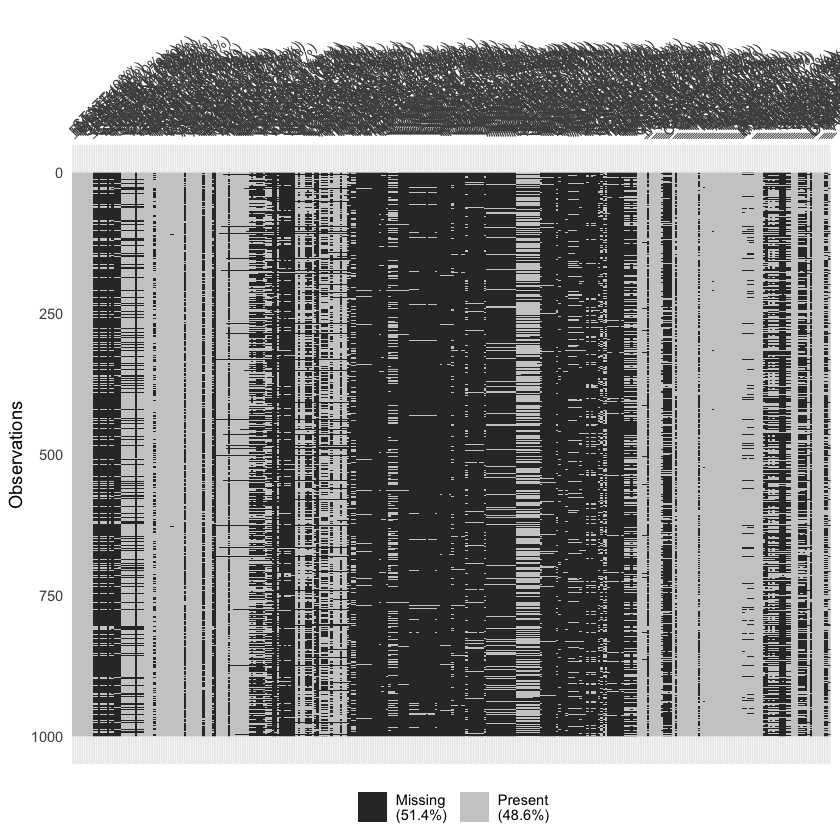

In [25]:
vis_miss(llcp |> slice_sample(n = 1000))

In [60]:
x <- llcp %>%
    drop_na(MARIJAN1)

x <- x %>%
    select(where(~ sum(is.na(.)) < 5000))
    
x <- x %>%
    mutate(na_count = apply(., 1, function(x) sum(is.na(x)))) %>%
    filter(na_count < 20) 

In [64]:
x

_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,SEXVAR,...,_RFSMOK3,_CURECI2,_SMOKGRP,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_AIDTST4,na_count
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
9,1,02082022,02,08,2022,1100,2022000006,2.022e+09,2,...,1,1,4,2,0,1,0,1,9,0
9,1,02042022,02,04,2022,1100,2022000007,2.022e+09,2,...,1,1,4,2,0,1,0,1,2,0
9,1,02162022,02,16,2022,1100,2022000008,2.022e+09,2,...,1,1,3,1,67,1,933,2,1,0
9,1,02082022,02,08,2022,1100,2022000010,2.022e+09,1,...,1,1,4,2,0,1,0,1,1,0
9,1,02122022,02,12,2022,1100,2022000011,2.022e+09,2,...,1,1,2,1,43,1,300,1,2,0
9,1,02152022,02,15,2022,1100,2022000012,2.022e+09,2,...,1,1,4,2,0,1,0,1,2,0
9,1,02082022,02,08,2022,1100,2022000013,2.022e+09,2,...,1,1,4,2,0,1,0,1,1,0
9,2,02182022,02,18,2022,1100,2022000014,2.022e+09,2,...,2,1,1,2,0,1,0,1,1,0
9,2,02232022,02,23,2022,1100,2022000015,2.022e+09,2,...,1,1,3,1,33,1,233,1,1,0


## National Survey on Drug Use and Health: 2021

The National Survey on Drug Use and Health (NSDUH) is a survey conducted by the Substance Abuse and Mental Health Services Administration (SAMHSA) that collects data on substance use and mental health in the United States. The survey data is shared as a `.RData` file, so we will use `R` to clean this data.

First, let's take care of all the missing data. The NSDUH uses different numeric codes to represent missing data, so we will replace it with `NA` where appropriate.

In [6]:
load("../../data/raw_data/NSDUH_2021.RData")

In [7]:
nsduh_2021 <- PUF2021_100622
rm(PUF2021_100622)
nsduh_2021 <- nsduh_2021 %>%
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(91, 991, 9991), "Never Used", .))
    ) %>% 
    mutate(
        across(where(is.numeric), ~ifelse(. %in% c(93, 993, 9993), "Not Used in Period of Interest", .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(94, 994, 9994), "Don't Know", .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(97, 997, 9997), "Refused", .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(98, 998, 9998), NA, .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(99, 999, 9999), NA, .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(81, 981, 9981), "Never Used", .))
    ) %>% 
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(83, 983, 9983), "Not Used in Period of Interest", .))
    ) %>%
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(85, 985, 9985), "Bad Data", .))
    ) %>%
    mutate(
        across(where(is.numeric),
        ~ifelse(. %in% c(89, 989, 9989), NA, .))
    )

In [8]:
dim(nsduh_2021)

[1] 58034  2988

This data set is very large, offering survey data on drug and alcohol use alongside mental health data on almost 60,000 individuals. It also contains almost 3000 variables.

We will focus on removing the variables that are not relevant or highly correlated. We will also get rid of the missing data throughout the data set. Let's start by getting rid of the missing data.

In [9]:
columns_to_drop <- nsduh_2021 %>%
    summarise(across(everything(), ~ sum(is.na(.)) / n())) %>%
    pivot_longer(everything()) %>%
    filter(value > 0.5) %>%
    pull(name)

nsduh_2021 <- nsduh_2021 %>%
    select(-all_of(columns_to_drop))

In [10]:
nsduh_2021 %>% dim()

[1] 58034  2658

Now we've dropped about 300 columns with a lot of missing data. Next, we'll get rid of some of the very highly correlated columns.

In [11]:
cor_matrix <- nsduh_2021 %>%
    select(where(is.numeric)) %>%
    cor(use = "pairwise.complete.obs")

Warning message in cor(., use = "pairwise.complete.obs"):
"the standard deviation is zero"


In [12]:
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables
cor_matrix[upper.tri(cor_matrix)] <- 0
cor_matrix |> diag() <- 0

nsduh_2021 <- nsduh_2021[, apply(cor_matrix, 2, function(x) all(abs(x) < 0.9, na.rm = TRUE))]

In [18]:
# Impute all the missing values with k-nearest neighbors
library(tidymodels)

recipe <- recipe(smipppy ~ ., data = nsduh_2021) %>%
    # Remove columns with no variance
    step_nzv(all_predictors()) %>%
    # Impute missing values using k-nearest neighbors
    step_impute_knn(all_predictors(), neighbors = 5)

nsduh_2021 <- bake(prep(recipe, training = nsduh_2021), new_data = nsduh_2021)

In [ ]:
save(nsduh_2021, file = "../../data/clean_data/nsduh_2021.RData")

In [ ]:
write_csv(nsduh_2021, file = "../../data/clean_data/nsduh_2021.csv")